Step 19 (Speical Topic 3): Optimization of Dynamical Systems
----
***

In this step, we integrate a forward Partial Differential Equation (PDE) solver with an optimization algorithm to fine-tune input parameters, ensuring that the solver's output aligns with specified target values. Utilizing [Automatic Differentiation](https://jax.readthedocs.io/en/latest/jax-101/04-advanced-autodiff.html) in JAX, we can effortlessly compute derivatives of the model output with respect to the input parameters. This capability facilitates the use of gradient-based optimization algorithms, such as the gradient descent method, for efficient exploration of the parameter space. While this step employs an Ordinary Differential Equation (ODE) as the forward solver, the optimization framework is versatile and can be applied to other ODE and PDE solvers.

In [1]:
import jax
import jax.numpy as np
from jax import linear_util as lu
from jax.flatten_util import ravel_pytree
import numpy as onp
from functools import partial
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys


A brief explanation has been given below about what this program does.

Define a Dynamical System: It sets up a mathematical model that describes how a dynamical system (specifically, the Lorenz system) evolves over time. This model involves equations that govern how the system's variables change with time.

Numerical Integration: It uses a numerical method (Runge-Kutta 4th order) to simulate the behavior of the dynamical system over a range of time points. This involves repeatedly applying the equations from the dynamical system to calculate how the system's variables change at each time step.

Gradient Computation: It calculates how sensitive the system's behavior is to changes in its parameters. This is important for understanding how small adjustments to certain parameters affect the system's output. The program computes these gradients using different methods, including finite differences and automatic differentiation.

Optimization: It tries to find the best-fitting parameters for the dynamical system by minimizing the difference between the system's behavior and a target state. In other words, it adjusts the parameters to make the simulated system's output as close as possible to the desired outcome.

Printing Results: The program then prints out the estimated parameters that make the model fit the target state most closely. It also shows the initial parameters and the ground truth parameters for comparison.

In simple terms, this program simulates a dynamic system, like weather patterns or fluid flow, and tries to figure out the rules that govern it. It does this by adjusting parameters in a mathematical model until the model's predictions match real-world observations as closely as possible.







### Define dynamical system

#### Lorenz System
The Lorenz system was initially derived from a Oberbeck-Boussinesq approximation. This approximation is
a coupling of the Navier-Stokes equations with thermal convection. The original problem was a 2D problem
considering the thermal convection between two parallel horizontal plates. The Lorenz system arises from
using a truncated Fourier-Galerkin expansion.

$$\frac{dx}{dt}=\sigma(y-x),$$ 
$$\frac{dy}{dt}=x(\rho-z)-y,$$ 
$$\frac{dz}{dt}=xy-\beta z ,$$ <br>
>where,
$\sigma \,$ is the Prandle number\, 
$\rho \, $ is a scaled value of Rayleigh number and $\beta \,$ is an aspect ratio 








In [2]:
def Lorenz_rhs_func(state, t, ode_params):
    rho, sigma, beta = ode_params
    x, y, z = state
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

### Runge-Kutta Method
RK method is widely used for solving initial value problems of differential equation by constructing higher order approximation of a differential problem. 4th order variant, or RK4 produces more accurate result than other simpler numerical methods.

In the code, h is the small time step, $k_1$ is the slope at the initial value, derived simply from euler's method.
 $k_2$ and $k_3$ both are slope at midpoint of the interval h, but using $k_1$ and $k_2$ respectively for calculating. And $k_4$ is the slope at the end-point. Weighted average of these 4 slopes is used to calculate a more accurate estimation of the endpoint.


In [3]:
# About the decorator: f is a function (not JAX array) and JAX needs to know that so we specify it as "static"
@partial(jax.jit, static_argnums=(2,))
def rk4(state, t_crt, f, ode_params):
    y_prev, t_prev = state
    h = t_crt - t_prev
    k1 = h * f(y_prev, t_prev, ode_params)
    k2 = h * f(y_prev + k1/2., t_prev + h/2., ode_params)
    k3 = h * f(y_prev + k2/2., t_prev + h/2., ode_params)
    k4 = h * f(y_prev + k3, t_prev + h, ode_params)
    y_crt = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return (y_crt, t_crt), y_crt

In [4]:
#ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_opt)

#stepper is the interative solver, here it is RK4 method
#f is funcition to operate; here which is Lorenz function
#ts = np.arange(0, 101*dt, dt)
#rho, sigma, beta = ode_params
#odeint takes system function, ode parameters as input and calculates space values of the system at progressing small time difference
def odeint(stepper, f, y0, ts, ode_params):

    def stepper_partial(state, t_crt):
        #stepper function is used to advance the state of an ODE system from one time point to another. Output contains new state, new time
        return stepper(state, t_crt, f, ode_params)

    ys = []
    state = (y0, ts[0])
    for (i, t_crt) in enumerate(ts[1:]):
        state, y = stepper_partial(state, t_crt)
        #print("state, y", state, y)
        ys.append(y)
    ys = np.array(ys)
    #print("ys =", ys)
    return ys

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


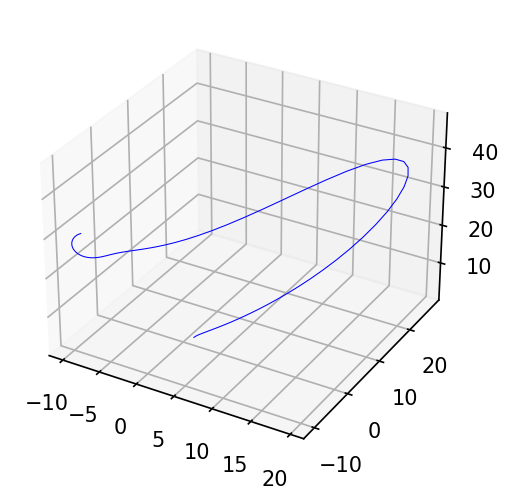

In [5]:
#print("dumba")
y0 = np.array([1., 1., 1.])
dt = 1e-2
ts = np.arange(0, 101*dt, dt) # ts defined for optimization
#ts_plot = np.arange(0, 5001*dt, dt) # ts defined for visulization here
ode_params_gt = [28., 10., 8./3.]

ys_gt_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_gt)

ys_gt = np.vstack((y0[None, ...], ys_gt_))
#ys_gt is the array consisting the states or space value over time of Lorenz System
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(projection='3d')
x0, x1, x2 = ys_gt.T
ax.plot(x0, x1, x2, lw=0.5, color='b')

### Compute derivatives with several methods

#### Finite Difference Based Gradient Computing Function

$$\frac{d}{dt}f(x)=\lim_{h \to 0} \frac{f(x+h)-f(x-h)}{2h} $$

In [6]:
def compute_gradient_fd(ys, ts, obj_func, state_rhs_func, ode_params):
    print(f"running finite difference")
    
    y0 = ys[0]
    h = 1e-1
    ode_params_flat, unravel = ravel_pytree(ode_params)

    grads = []
    for i in range(len(ode_params_flat)):
        ode_params_flat_plus = ode_params_flat.at[i].add(h)
        ys_plus_ = odeint(rk4, state_rhs_func, y0, ts, unravel(ode_params_flat_plus))
        tau_plus = obj_func(ys_plus_[-1])
           
        ode_params_flat_minus = ode_params_flat.at[i].add(-h)
        ys_minus_ = odeint(rk4, state_rhs_func, y0, ts, unravel(ode_params_flat_minus))
        tau_minus = obj_func(ys_minus_[-1])
        
        grad = (tau_plus - tau_minus) / (2 * h)
        grads.append(grad)

    grads = unravel(np.array(grads))

    return grads

In [7]:
# a = 1,2,3
# print(a)
# b, unravel = ravel_pytree(a)
# print(b)
# c = unravel(b)
# print(c)

#### Automatic Differentiation

In automatic differentiation (AD), numerical methods like finite differences are not used for calculating derivatives in each step. Instead, AD relies on symbolic manipulation or dual numbers to compute exact derivatives. This is one of the fundamental differences between AD and numerical differentiation methods, such as finite differences.

Here's a brief explanation of how derivatives are calculated in each step of AD without numerical approximation:

Symbolic Manipulation: In the forward and reverse modes of AD, derivatives are calculated symbolically, not numerically. This means that the elementary operations used to compute the derivative are represented in terms of their symbolic derivatives. 

Dual Numbers: Dual numbers are an extension of real numbers that include an infinitesimal component (ε). In AD, dual numbers are used to simultaneously track the function value and its derivative. For example, if x is a dual number representing a variable, it might be written as x = a + ε * b, where a is the function value, and b is its derivative with respect to x. As you perform operations on dual numbers, AD updates both the function value and its derivative using the rules of elementary calculus.

Chain Rule: AD applies the chain rule systematically during the calculation of derivatives. When you have a composite function, AD knows how to combine the derivatives of elementary operations using the chain rule to compute the derivative of the entire function.

By working symbolically with dual numbers and using the chain rule, AD can compute derivatives accurately and efficiently without the need for numerical approximations. This allows it to calculate derivatives at each step of the computation, providing exact gradients or derivatives rather than approximations that would be obtained through numerical methods like finite differences.

In [8]:
def compute_gradient_ad_diff_through_loops(ys, ts, obj_func, state_rhs_func, ode_params):
    print(f"running autodiff, differentiate through loops")

    y0 = ys[0]
    def func(ode_params):
        ys_ = odeint(rk4, state_rhs_func, y0, ts, ode_params)
        return obj_func(ys_[-1])

    #jax.grad(FUNCTION) is afunction fron jax library which is used for differentiating "FUNCTION" using automatic differentiation
    grad_func = jax.grad(func)
    grads = grad_func(ode_params)
    
    return grads

In [9]:
import time

def obj_func(yf, target_yf):
    return np.sum((yf - target_yf)**2)

target_yf = ys_gt_[-1]
obj_func_partial = lambda yf: obj_func(yf, target_yf)

# ode_params_0 = [np.array([26., 8., 2.])]
ode_params_0 = [26., 8., 2.]

ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_0)
ys = np.vstack((y0[None, ...], ys_))


grads_fd = compute_gradient_fd(ys, ts, obj_func_partial, Lorenz_rhs_func, ode_params_0)
print(f"grads = {grads_fd}\n")

grads_ad_diff_through_loops = compute_gradient_ad_diff_through_loops(ys, ts, obj_func_partial, Lorenz_rhs_func, ode_params_0)
print(f"grads = {grads_ad_diff_through_loops}\n")



running finite difference


grads = [Array(-7.501421, dtype=float32), Array(16.432524, dtype=float32), Array(-102.63889, dtype=float32)]

running autodiff, differentiate through loops


grads = [Array(-7.498921, dtype=float32, weak_type=True), Array(16.436684, dtype=float32, weak_type=True), Array(-102.749664, dtype=float32, weak_type=True)]



The case study above demonstrates that both finite difference methods and automatic differentiation (autodiff) yield approximately similar results. In our next simplified example, we will illustrate how autodiff not only achieves greater accuracy but also proves to be more efficient than the finite difference method.

In [10]:
from numpy.matrixlib import defmatrix
from jax.config import config
config.update("jax_enable_x64", True)

def sum_logistic(x):
  return np.sum(1.0 / (1.0 + np.exp(-x)))

x_small = np.arange(100.)
#y_small = np.linspace(0,3,100)

derivative_fn = jax.grad(sum_logistic)  # define a function which is the gradient of sum_logistic
%timeit derivative_fn(x_small)
print(derivative_fn(x_small))

2.24 ms ± 49.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[2.50000000e-01 1.96611933e-01 1.04993585e-01 4.51766597e-02
 1.76627062e-02 6.64805667e-03 2.46650929e-03 9.10221180e-04
 3.35237671e-04 1.23379350e-04 4.53958077e-05 1.67011429e-05
 6.14413685e-06 2.26031919e-06 8.31527336e-07 3.05902133e-07
 1.12535149e-07 4.13993738e-08 1.52299793e-08 5.60279637e-09
 2.06115361e-09 7.58256042e-10 2.78946809e-10 1.02618796e-10
 3.77513454e-11 1.38879439e-11 5.10908903e-12 1.87952882e-12
 6.91440011e-13 2.54366565e-13 9.35762297e-14 3.44247711e-14
 1.26641655e-14 4.65888615e-15 1.71390843e-15 6.30511676e-16
 2.31952283e-16 8.53304763e-17 3.13913279e-17 1.15482242e-17
 4.24835426e-18 1.56288219e-18 5.74952226e-19 2.11513104e-19
 7.78113224e-20 2.86251858e-20 1.05306174e-20 3.87399763e-21
 1.42516408e-21 5.24288566e-22 1.92874985e-22 7.09547416e-23
 2.61027907e-23 9.60268005e-24 3.53262857e-24 1.29958143e-24
 4.78089288e-25 1.75879220e-25 6.47023493e-26 2.38026641e-26
 8.75651076e-

In [11]:
def first_finite_differences(f, x):
  eps = 1e-6
  return np.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in np.eye(len(x))])

%timeit first_finite_differences(sum_logistic, x_small)
print(first_finite_differences(sum_logistic, x_small))

12.6 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
[2.49999999e-01 1.96611936e-01 1.04993582e-01 4.51766624e-02
 1.76626997e-02 6.64805810e-03 2.46650700e-03 9.10219455e-04
 3.35241168e-04 1.23378641e-04 4.53965754e-05 1.66977543e-05
 6.14619466e-06 2.25952590e-06 8.31335001e-07 3.05533376e-07
 1.13686838e-07 4.26325641e-08 1.42108547e-08 7.10542736e-09
 7.10542736e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0

### Optimization

In [12]:

## optimize(ode_params_0, y0, ts, obj_func_partial, Lorenz_rhs_func, bounds, compute_gradient_fd)

def optimize(ode_params_0, y0, ts, obj_func, state_rhs_func, bounds, compute_gradient_func):
    x_ini, unravel = ravel_pytree(ode_params_0)
    obj_vals = []

    def objective(x):
        print(f"\n######################### Evaluating objective value - step {objective.counter}")
        x = np.array(x)
        ode_params = unravel(x)
        ys_ = odeint(rk4, state_rhs_func, y0, ts, ode_params)
        ys = np.vstack((y0[None, ...], ys_))
        obj_val = obj_func(ys[-1])

        objective.ode_params = ode_params
        objective.ys = ys
        objective.x = ode_params

        objective.counter += 1
        obj_vals.append(obj_val)

        print(f"obj_val = {obj_val}")
        print(f"ode_params = {ode_params}")
        print(f"ys[-1] = {ys[-1]}")

        return obj_val

    def derivative(x):
        ode_params = objective.ode_params
        ys = objective.ys

        grads = compute_gradient_func(ys, ts, obj_func, state_rhs_func, ode_params)
        print(f"########################################################")
        print(f"grads = {grads}")
        print(f"########################################################")

        grads_ravelled, _ = ravel_pytree(grads)
        # 'L-BFGS-B' requires the following conversion, otherwise we get an error message saying
        # -- input not fortran contiguous -- expected elsize=8 but got 4
        return onp.array(grads_ravelled, order='F', dtype=onp.float64)

    objective.counter = 0
    options = {'maxiter': 1000, 'disp': True}  # CG or L-BFGS-B or Newton-CG or SLSQP
    res = opt.minimize(fun=objective,
                       x0=x_ini,
                       method='SLSQP',
                       jac=derivative,
                       bounds=bounds,
                       callback=None,
                       options=options)
        
    return objective.x

### Solving the inverse problem using Finite Difference Method

In [13]:
#just some arrays containing two variables, probably x, y space value, let's see

bounds = np.array([[26., 30.], [8., 12.], [8./3., 8./3.]])

#calling the main optimizing function, let's go to optimize function, it takes 7 input arguments


ode_params_opt = optimize(ode_params_0, y0, ts, obj_func_partial, Lorenz_rhs_func, bounds, compute_gradient_fd)



#optimized ode paramaters derived from optimize function would be an inpur argument of odeint function

ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_opt)

print(f"\nGround truth parameter values = {ode_params_gt}")
print(f"Ground truth yf = {target_yf}")
print(f"\nInitial parameter values = {ode_params_0}")
print(f"Optimized parameter values = {ode_params_opt}")
print(f"Optimized yf = {ys_[-1]}")


######################### Evaluating objective value - step 0


obj_val = 4.860941287589725
ode_params = [Array(26., dtype=float64), Array(8., dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-10.52796043 -10.17111714  28.86326064]
running finite difference
########################################################
grads = [Array(-6.92301708, dtype=float64), Array(-5.14942292, dtype=float64), Array(18.96074537, dtype=float64)]
########################################################

######################### Evaluating objective value - step 1
obj_val = 4.410157956860218
ode_params = [Array(30., dtype=float64), Array(12., dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.98216602 -9.483049   31.02914495]

######################### Evaluating objective value - step 2
obj_val = 4.5308537838420157e-05
ode_params = [Array(28.01884586, dtype=float64), Array(10.01884586, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.37604064 -8.36218931 29.36591822]
running finite difference


########################################################
grads = [Array(-0.00014405, dtype=float64), Array(0.00261211, dtype=float64), Array(-0.55425541, dtype=float64)]
########################################################

######################### Evaluating objective value - step 3
obj_val = 4.3328425968302456e-05
ode_params = [Array(28.01976363, dtype=float64), Array(10.01664552, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.37537389 -8.36062631 29.36688514]
running finite difference
########################################################
grads = [Array(0.00207508, dtype=float64), Array(5.73364305e-05, dtype=float64), Array(-0.53331802, dtype=float64)]
########################################################

######################### Evaluating objective value - step 4
obj_val = 4.106380298681398e-05
ode_params = [Array(28.01908555, dtype=float64), Array(10.01675259, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.37560073 -8.36089563 29.366556

########################################################
grads = [Array(-0.00062246, dtype=float64), Array(0.00158433, dtype=float64), Array(-0.55303034, dtype=float64)]
########################################################

######################### Evaluating objective value - step 7
obj_val = 1.3800534692919301e-05
ode_params = [Array(28.01067905, dtype=float64), Array(10.01033877, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.37707385 -8.35974055 29.36446013]
running finite difference
########################################################
grads = [Array(-0.00061286, dtype=float64), Array(0.0008233, dtype=float64), Array(-0.55015333, dtype=float64)]
########################################################
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3800534692919301e-05
            Iterations: 7
            Function evaluations: 8
            Gradient evaluations: 7

Ground truth parameter values = [28.0, 10.0, 2.6

### Solving the inverse problem using Automatic Differentiation Method

In [14]:
#just some arrays containing two variables, probably x, y space value, let's see

bounds = np.array([[26., 30.], [8., 12.], [8./3., 8./3.]])

#calling the main optimizing function, let's go to optimize function, it takes 7 input arguments


ode_params_opt = optimize(ode_params_0, y0, ts, obj_func_partial, Lorenz_rhs_func, bounds, compute_gradient_ad_diff_through_loops)



#optimized ode paramaters derived from optimize function would be an inpur argument of odeint function

ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_opt)

print(f"\nGround truth parameter values = {ode_params_gt}")
print(f"Ground truth yf = {target_yf}")
print(f"\nInitial parameter values = {ode_params_0}")
print(f"Optimized parameter values = {ode_params_opt}")
print(f"Optimized yf = {ys_[-1]}")


######################### Evaluating objective value - step 0
obj_val = 4.860941287589725
ode_params = [Array(26., dtype=float64), Array(8., dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-10.52796043 -10.17111714  28.86326064]
running autodiff, differentiate through loops


########################################################
grads = [Array(-6.91298213, dtype=float64), Array(-5.130735, dtype=float64), Array(19.05076497, dtype=float64)]
########################################################

######################### Evaluating objective value - step 1
obj_val = 4.410157956860218
ode_params = [Array(30., dtype=float64), Array(12., dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.98216602 -9.483049   31.02914495]

######################### Evaluating objective value - step 2
obj_val = 4.5530123214976924e-05
ode_params = [Array(28.01889123, dtype=float64), Array(10.01889123, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.37603467 -8.36220193 29.36592691]
running autodiff, differentiate through loops


########################################################
grads = [Array(0.0015845, dtype=float64), Array(0.00330562, dtype=float64), Array(-0.00253483, dtype=float64)]
########################################################

######################### Evaluating objective value - step 3
obj_val = 4.1048447656296876e-05
ode_params = [Array(28.01911315, dtype=float64), Array(10.01666937, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.37557771 -8.36083868 29.36658988]
running autodiff, differentiate through loops


########################################################
grads = [Array(0.00328236, dtype=float64), Array(0.00121416, dtype=float64), Array(0.01374493, dtype=float64)]
########################################################

######################### Evaluating objective value - step 4
obj_val = 3.360539721002528e-05
ode_params = [Array(28.01746655, dtype=float64), Array(10.01439108, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.3756862  -8.3600138  29.36643895]
running autodiff, differentiate through loops


########################################################
grads = [Array(0.00358246, dtype=float64), Array(0.00035915, dtype=float64), Array(0.01818499, dtype=float64)]
########################################################

######################### Evaluating objective value - step 5
obj_val = 5.834839648128331e-06
ode_params = [Array(28.00678528, dtype=float64), Array(10.00410361, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.3772091  -8.35732328 29.36434815]
running autodiff, differentiate through loops


########################################################
grads = [Array(0.00243928, dtype=float64), Array(-0.00119133, dtype=float64), Array(0.01707735, dtype=float64)]
########################################################

######################### Evaluating objective value - step 6
obj_val = 2.3090861427081626e-07
ode_params = [Array(28.00056728, dtype=float64), Array(9.99978854, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.3784044  -8.35675983 29.36271278]
running autodiff, differentiate through loops


########################################################
grads = [Array(0.0005957, dtype=float64), Array(-0.00058269, dtype=float64), Array(0.00519343, dtype=float64)]
########################################################
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3090861427081626e-07
            Iterations: 6
            Function evaluations: 7
            Gradient evaluations: 6

Ground truth parameter values = [28.0, 10.0, 2.6666666666666665]
Ground truth yf = [-9.378615  -8.3570595 29.362402 ]

Initial parameter values = [26.0, 8.0, 2.0]
Optimized parameter values = [Array(28.00056728, dtype=float64), Array(9.99978854, dtype=float64), Array(2.66666667, dtype=float64)]
Optimized yf = [-9.3784044  -8.35675983 29.36271278]
